<a href="https://colab.research.google.com/github/iKatePy/Study_projects/blob/master/NumplatesOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognition with EasyOCR

Цель работы - определение номеров по короткому видео

Aim of this work is to recognize numplates from short video file

Работа выполнена в Google Colab.
Для корректной работы необходимо загрузить:

    файл с видео (видеосъёмка автомобилей с российскими номерами) — cam1.mp4

    файл каскадного классификатора — haarcascade_russian_plate_number.xml

This project was completed in Google Colab.
For correct operation, you need to upload:

    a video file (car traffic with Russian license plates) — cam1.mp4

    the cascade classifier file — haarcascade_russian_plate_number.xml


In [1]:
from google.colab import files

# Загружаем видео / Uploading video
uploaded = files.upload()
for filename in uploaded.keys():
    print(f'Загружен файл: {filename}')

Saving cam1.mp4 to cam1.mp4
Saving haarcascade_russian_plate_number.xml to haarcascade_russian_plate_number.xml
Загружен файл: cam1.mp4
Загружен файл: haarcascade_russian_plate_number.xml


## Установка easyOCR и Levenshtein / Installation of easyOCR and Levenshtein

In [2]:
pip install easyOCR

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [3]:
pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.8 MB/s eta 0:00:00




 Index Raw OCR Text Formatted Number CER H764KE 799 CER С005KM 190 CER A715AE 977
     0    Н764КЕ799       Н764КЕ 799            0.3              -              -
     1      Н764Е79         Н764 079            0.5              -              -
     2       СОО56М          С00 560              -            0.5              -
     3    СОО5КМ190       С005КМ 190              -            0.2              -
     4    СОО5КМ190       С005КМ 190              -            0.2              -
     5    47154Е977       А715АЕ 977              -              -            0.3
     6    А71546977       А715АК 977              -              -            0.3


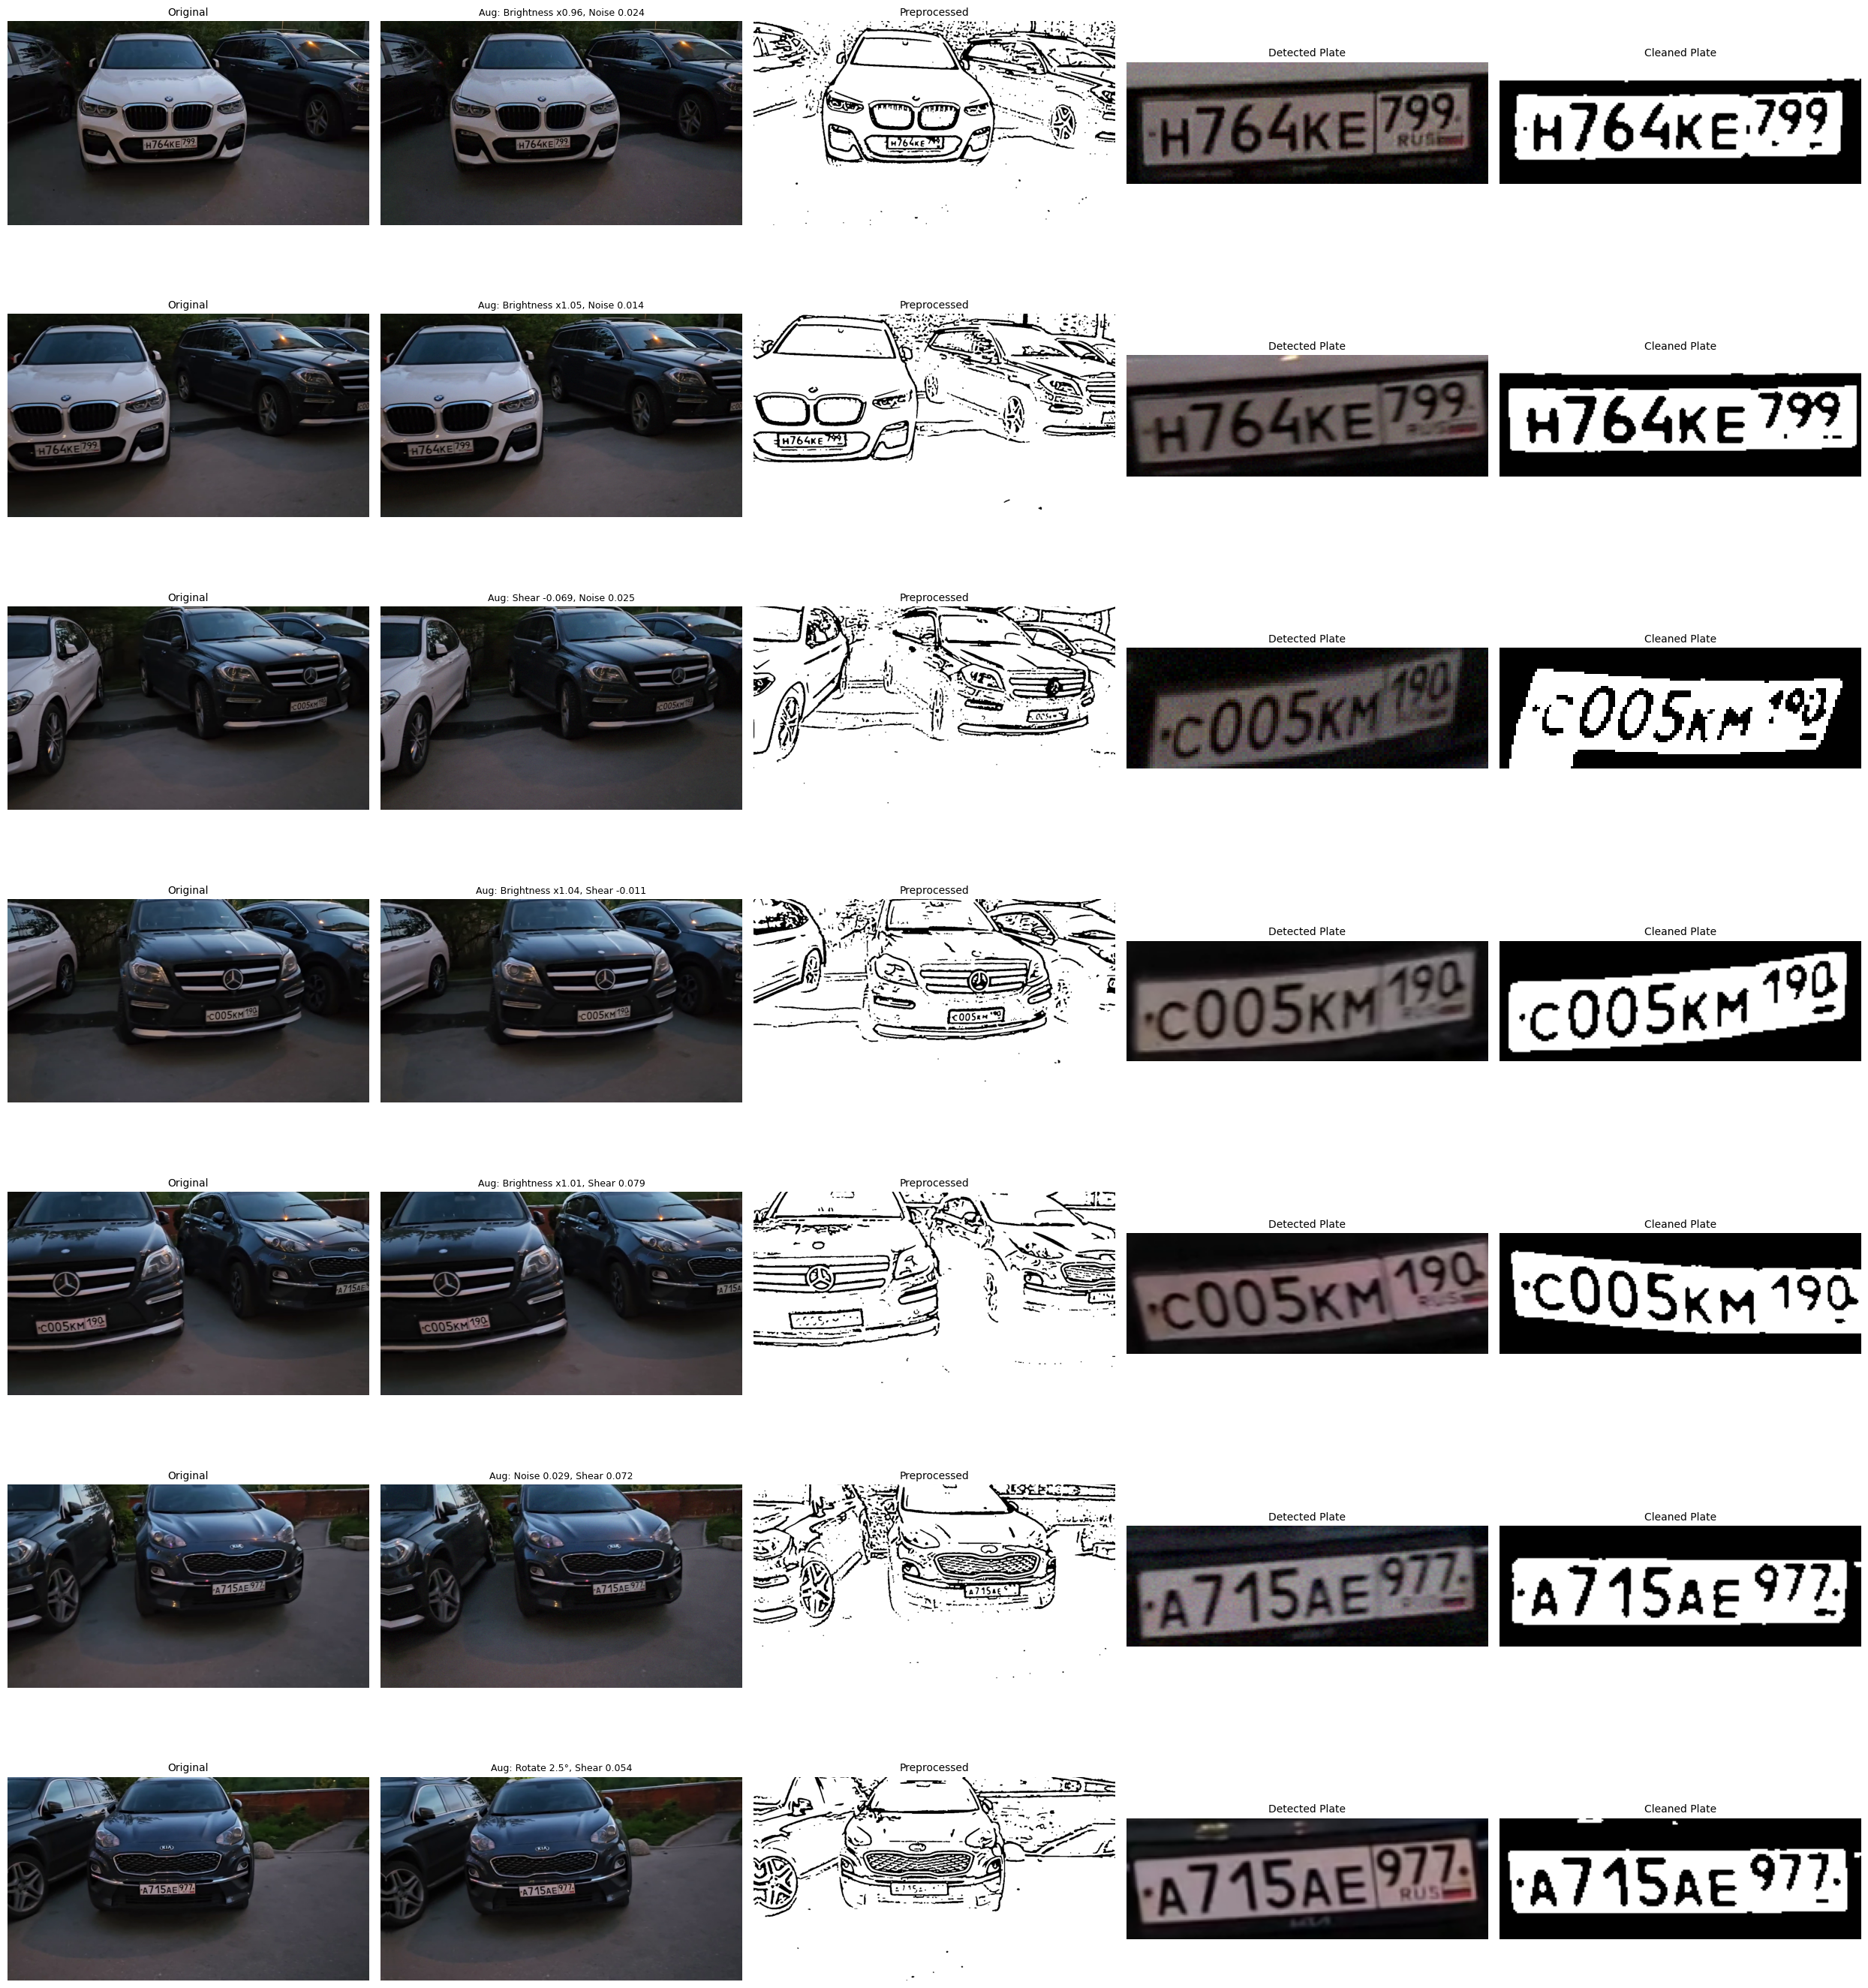

In [5]:
import cv2
import numpy as np
import pandas as pd
import random
import easyocr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import re
from Levenshtein import distance

# --- Инициализация EasyOCR --- / # --- EasyOCR Initialization ---
# Для лучших результатов установи gpu=True, если доступен (T4 в google colab)
# Set gpu=True  if available for better results (T4 in google colab)
reader = easyocr.Reader(['ru', 'en'], gpu=False)

# --- Функции аугментации --- / # --- Augmentation Functions ---
def random_rotate(image):
    angle = random.uniform(-5, 5)
    h, w = image.shape[:2]
    matrix = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    rotated = cv2.warpAffine(image, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    return rotated, f"Rotate {angle:.1f}°"  # Поворот изображения на случайный угол / # Rotate image by a random angle

def random_brightness(image):
    factor = random.uniform(0.95, 1.05)
    bright = np.clip(image * factor, 0, 255).astype(np.uint8)
    return bright, f"Brightness x{factor:.2f}"  # Изменение яркости изображения / # Change image brightness

def random_noise(image):
    noise_level = random.uniform(0.01, 0.03)
    noise = np.random.randn(*image.shape) * 255 * noise_level
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return noisy_image, f"Noise {noise_level:.3f}"  # Добавление случайного шума / # Add random noise

def random_shear(image):
    max_shear = 0.1
    shear_factor = random.uniform(-max_shear, max_shear)
    h, w = image.shape[:2]
    matrix = np.array([[1, shear_factor, 0],
                       [0, 1, 0]], dtype=np.float32)
    sheared = cv2.warpAffine(image, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    return sheared, f"Shear {shear_factor:.3f}"  # Сдвиг изображения (сдвиг по оси X) / # Shear image (shift along X axis)

augmentation_functions = [
    random_rotate,
    random_brightness,
    random_noise,
    random_shear
]

def apply_random_augmentations(image, num_augmentations=2):
    augmented = image.copy()
    chosen = random.sample(augmentation_functions, num_augmentations)
    descriptions = []
    for aug in chosen:
        augmented, desc = aug(augmented)
        descriptions.append(desc)
    return augmented, descriptions  # Применение случайных аугментаций к изображению / # Apply random augmentations to the image

# --- Автоматическая ориентация (ограничение угла) --- / # --- Automatic orientation (limited angle) ---
def auto_rotate(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Используем HoughLinesP для обнаружения линий / # Use HoughLinesP to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)

    if lines is not None:
        angles = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))

            # Ограничиваем угол до ±45 градусов / # Limit angle to ±45 degrees
            angle = max(-45, min(45, angle))
            angles.append(angle)

        median_angle = np.median(angles)

        # Если угол слишком большой, возможно, нужно повернуть в другую сторону / # If angle is too large, might need to rotate the other way
        if median_angle < -45:
            median_angle += 90
        elif median_angle > 45:
            median_angle -= 90

        if abs(median_angle) > 0:
            h, w = image.shape[:2]
            matrix = cv2.getRotationMatrix2D((w / 2, h / 2), median_angle, 1)
            rotated = cv2.warpAffine(image, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
            return rotated  # Поворот изображения на вычисленный угол / # Rotate image by the computed angle

    return image  # Возврат исходного изображения, если линии не найдены / # Return original image if no lines found

# --- Предобработка изображения --- / # --- Image Preprocessing ---
def preprocess(img, invert=True):
    oriented = auto_rotate(img)
    denoised = cv2.fastNlMeansDenoisingColored(oriented, None, h=3, hColor=3, templateWindowSize=7, searchWindowSize=21)
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (9, 9), 0)
    gray = cv2.medianBlur(gray, 5)
    edges = cv2.Canny(gray, 50, 150)
    gray = cv2.addWeighted(gray, 1.0, edges, 0.5, 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast = clahe.apply(gray)
    _, binary_otsu = cv2.threshold(contrast, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binary_adaptive = cv2.adaptiveThreshold(contrast, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY_INV, 11, 2)
    binary = cv2.bitwise_and(binary_otsu, binary_adaptive)
    binary = cv2.medianBlur(binary, 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    if invert:
        binary = cv2.bitwise_not(binary)
    return binary

# --- Детекция номерного знака --- / # --- License Plate Detection ---
def get_plate(img):
    plate_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_russian_plate_number.xml')
    gray = img if len(img.shape) == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plates = plate_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in plates:
        return img[y:y+h, x:x+w], (x, y, w, h)
    return None, None

# --- Очистка номера для OCR --- / # --- Plate Cleaning for OCR ---
def correct_plate_orientation(plate_img):
    if len(plate_img.shape) == 3:  # Цветное изображение / # Color image
        gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    else:  # Уже в градациях серого / # Already grayscale
        gray = plate_img

    edges = cv2.Canny(gray, 100, 200, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30,
                            minLineLength=plate_img.shape[1]//3,
                            maxLineGap=5)

    if lines is not None:
        angles = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.degrees(np.arctan2(y2-y1, x2-x1))
            if -20 < angle < 20:  # Строгие ограничения по углу / # Strict angle limits
                angles.append(angle)

        if angles:
            median_angle = np.median(angles)
            if abs(median_angle) > 0.5:  # Поворот только при значительном угле / # Rotate only if significant angle
                h, w = plate_img.shape[:2]
                M = cv2.getRotationMatrix2D((w/2, h/2), median_angle, 1)
                return cv2.warpAffine(plate_img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return plate_img

def get_clean_plate(plate_img):
    """
    Финальная обработка номера для OCR / Final plate processing for OCR
    """
    if plate_img is None:
        return None

    # Коррекция наклона / # Correct skew
    rotated_plate = correct_plate_orientation(plate_img)

    # Конвертация в бинарное изображение / # Convert to binary image
    if len(rotated_plate.shape) == 3:  # Цветное изображение / # Color image
        hsv = cv2.cvtColor(rotated_plate, cv2.COLOR_BGR2HSV)
        v_channel = hsv[:, :, 2]
    else:  # Уже в градациях серого / # Already grayscale
        v_channel = rotated_plate

    _, binary = cv2.threshold(v_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = cv2.medianBlur(binary, 3)
    return binary

# --- OCR с EasyOCR --- / # --- OCR with EasyOCR ---
def get_raw_text(cleaned_plate):
    if cleaned_plate is None:
        return ""
    results = reader.readtext(cleaned_plate, detail=0, paragraph=False, allowlist='АВЕКМНОРСТУХ0123456789')
    text = ''.join(results).upper()
    text = ''.join(filter(str.isalnum, text))
    return text

# --- Форматирование распознанного текста --- / # --- Formatting Recognized Text ---
import re

def get_number(raw_text):
    """
    Преобразует распознанный текст номерного знака в стандартизированный формат.
    Converts recognized license plate text into a standardized format.

    Args:
        raw_text (str): Входной текст, полученный после OCR.
                        Input text obtained from OCR.

    Returns:
        str: Отформатированный номерной знак с разделением на основной номер и регион.
             Formatted license plate number with main part and region separated.
             Возвращает пустую строку, если входные данные некорректны.
             Returns empty string if input is invalid.
    """
    digit_to_letter = {'4': 'А', '6': 'К', '3': 'Е', '7': 'Т', '0': 'О', '5': 'С', '9': 'Г', '8': 'В', 'Б': 'Е'}
    letter_to_digit = {'В': '8', 'З': '2', 'О': '0'}  # Соответствие букв цифрам для региона / Letter to digit mapping for region

    # Предварительная очистка: удаляем пробелы и невидимые символы
    # Preliminary cleaning: remove spaces and invisible characters
    raw_text = raw_text.strip()              # Удалить пробелы в начале и конце / Remove leading and trailing spaces
    raw_text = raw_text.replace(' ', '')     # Удалить все пробелы внутри строки / Remove all spaces inside the string
    raw_text = re.sub(r'\s+', '', raw_text)  # Удалить все пробельные символы (табуляции, переносы и т.п.) / Remove all whitespace characters (tabs, newlines, etc.)

    raw_text = raw_text.upper()
    # Оставляем только русские буквы и цифры / Keep only Russian letters and digits
    text = re.sub(r'[^А-Я0-9]', '', raw_text)

    if len(text) < 6:
        # Если длина текста меньше 6, считаем данные некорректными / If text length is less than 6, consider input invalid
        return ""

    region_raw = text[-3:]  # Последние 3 символа — регион / Last 3 chars are region
    main_raw = text[:-3]    # Остальное — основной номер / The rest is main number

    # Обработка региона: замена букв на цифры / Process region: replace letters with digits
    region = ""
    for ch in region_raw:
        if ch in letter_to_digit:
            region += letter_to_digit[ch]
        elif ch.isdigit():
            region += ch
        else:
            region += '0'  # Если символ неизвестен, подставляем '0' / Unknown char replaced with '0'
    region = region.rjust(3, '0')  # Дополняем слева нулями до длины 3 / Pad left with zeros to length 3

    letter_positions = [0, 4, 5]  # Позиции букв в основном номере / Positions of letters in main number
    digit_positions = [1, 2, 3]   # Позиции цифр в основном номере / Positions of digits in main number

    main = list(main_raw.ljust(6))  # Дополняем основной номер пробелами до длины 6 / Pad main number with spaces to length 6

    # Коррекция символов в основном номере: буквы и цифры заменяются по словарям
    # Correct main number characters: replace letters and digits using mappings
    for pos in letter_positions:
        ch = main[pos] if pos < len(main) else ''
        if ch.isdigit() and ch in digit_to_letter:
            main[pos] = digit_to_letter[ch]
        elif ch.isalpha():
            main[pos] = ch
        else:
            main[pos] = ''

    for pos in digit_positions:
        ch = main[pos] if pos < len(main) else ''
        if ch in letter_to_digit:
            main[pos] = letter_to_digit[ch]
        elif ch.isdigit():
            main[pos] = ch
        else:
            main[pos] = ''

    result = ''.join(main[:6]) + ' ' + region
    return result

# --- Основной цикл обработки --- / # --- Main Processing Loop ---
num_images = 7 # Может изменять количество фото, извлеченных из видео / Can change the number of images extracted from video
video_path = 'cam1.mp4'
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_indices = np.linspace(0, total_frames - 1, num_images, dtype=int)

original_images = []
augmented_images = []
augmented_texts = []
preprocessed_images = []
plates = []
cleaned_plates = []
cleaned_plate_texts = []
formatted_numbers = []

for idx in frame_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    if not ret:
        continue

    original_images.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    augmented, texts = apply_random_augmentations(frame, num_augmentations=2)
    augmented_images.append(cv2.cvtColor(augmented, cv2.COLOR_BGR2RGB))
    augmented_texts.append(", ".join(texts))

    preprocessed = preprocess(augmented, invert=True)
    preprocessed_images.append(preprocessed)

    plate_img, bbox = get_plate(augmented)
    plates.append(plate_img)

    cleaned_plate = get_clean_plate(plate_img)
    cleaned_plates.append(cleaned_plate)

    raw_text = get_raw_text(cleaned_plate)
    cleaned_plate_texts.append(raw_text)

    formatted = get_number(raw_text)
    formatted_numbers.append(formatted)

cap.release()

# --- Вычисление метрики CER --- / # --- CER metric calculation ---
def calculate_cer(reference, hypothesis):
    return distance(reference, hypothesis) / max(len(reference), 1)

reference_plates = ["H764KE 799", "С005KM 190", "A715AE 977"]

cer_values = []
for number in formatted_numbers:
    cer_list = [calculate_cer(ref, number) for ref in reference_plates]
    cer_values.append(cer_list)

# --- Вывод таблицы --- / # --- Table output ---
df = pd.DataFrame({
    'Index': range(len(cleaned_plate_texts)),
    'Raw OCR Text': cleaned_plate_texts,
    'Formatted Number': formatted_numbers,
    'CER H764KE 799': [cer[0] for cer in cer_values],
    'CER С005KM 190': [cer[1] for cer in cer_values],
    'CER A715AE 977': [cer[2] for cer in cer_values]
})

# Создаем список столбцов с метриками CER для удобства / # Create list of CER metric columns for convenience
cer_cols = ['CER H764KE 799', 'CER С005KM 190', 'CER A715AE 977']

# Функция для обработки одной строки DataFrame / # Function to process one DataFrame row
def mark_incorrect_cers(row):
    # Находим минимальное значение CER и соответствующий столбец / # Find minimal CER value and corresponding column
    min_cer = row[cer_cols].min()
    if min_cer < 0.7:
        correct_col = row[cer_cols].idxmin()
        # Для всех остальных CER столбцов ставим "-" / # Set "-" for all other CER columns
        for col in cer_cols:
            if col != correct_col:
                row[col] = "-"
    else:
        # Если ни один CER не ниже 0.7, оставляем без изменений / # If no CER < 0.7, leave row unchanged
        pass
    return row

# Применяем функцию к каждой строке DataFrame / # Apply function to each DataFrame row
df = df.apply(mark_incorrect_cers, axis=1)

print("\n")
print(df.to_string(index=False))

# --- Визуализация --- / # --- Visualization ---
ncols = 5
nrows = len(original_images)
fig, axs = plt.subplots(nrows, ncols, figsize=(25, 4 * nrows))

for i in range(nrows):
    axs[i, 0].imshow(original_images[i])
    axs[i, 0].set_title('Original', fontsize=10)
    axs[i, 0].axis('off')

    axs[i, 1].imshow(augmented_images[i])
    axs[i, 1].set_title(f'Aug: {augmented_texts[i]}', fontsize=9)
    axs[i, 1].axis('off')

    axs[i, 2].imshow(preprocessed_images[i], cmap='gray')
    axs[i, 2].set_title('Preprocessed', fontsize=10)
    axs[i, 2].axis('off')

    if plates[i] is not None:
        axs[i, 3].imshow(cv2.cvtColor(plates[i], cv2.COLOR_BGR2RGB))
        axs[i, 3].set_title('Detected Plate', fontsize=10)
        axs[i, 3].axis('off')
    else:
        axs[i, 3].text(0.5, 0.5, 'No Plate Found', ha='center', va='center', fontsize=12, color='gray')
        axs[i, 3].axis('off')

    if cleaned_plates[i] is not None:
        axs[i, 4].imshow(cleaned_plates[i], cmap='gray')
        axs[i, 4].set_title('Cleaned Plate', fontsize=10)
        axs[i, 4].axis('off')
    else:
        axs[i, 4].text(0.5, 0.5, 'No Cleaned Plate', ha='center', va='center', fontsize=12, color='gray')
        axs[i, 4].axis('off')

plt.tight_layout()
plt.show()


## Выводы EasyOCR неплохо справляется с определением номеров, для улучшения результатов можно подключиться с ГПУ, попробовать добавить выравнивание перспективы для номера и морфологические операции